# Tutorial for analysis of patient outcome based on model parameters learned by `PICASA` using breast cancer dataset.

Read `PICASA` model file (previously trained on breast cancer data as descriped in tutorial 1) and original expression data.

In [8]:
import anndata as ad
import pandas as pd
import os 
import glob 
from picasa import model,dutil
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
from scipy.stats import zscore

sample ='brca'
pp = '/home/BCCRC.CA/ssubedi/projects/experiments/picasa/picasa_reproducibility/analysis/'


############ read model results as new_adata 
wdir = pp+sample
picasa_adata = ad.read_h5ad(wdir+'/model_results/picasa.h5ad')

adata = ad.read_h5ad(wdir+'/model_data/all_brca.h5ad')



Get model parameter (gene x factors) from unique net of `PICASA' model previously trained.

In [9]:

num_batches = len(picasa_adata.obs['batch'].unique())
input_dim = adata.shape[1]
nn_params = picasa_adata.uns['nn_params']
enc_layers = [128,25]
unique_latent_dim = nn_params['latent_dim']
common_latent_dim = nn_params['latent_dim']
dec_layers = [128,128]
nn_params['device'] = 'cpu'


picasa_unique_model = model.PICASAUniqueNet(input_dim,common_latent_dim,unique_latent_dim,enc_layers,dec_layers,num_batches).to(nn_params['device'])
picasa_unique_model.load_state_dict(torch.load(wdir+'/model_results/picasa_unique.model', weights_only=True,map_location=torch.device(nn_params['device'])))

picasa_unique_model.eval()


df_w = pd.DataFrame(picasa_unique_model.zinb_scale.weight.data.detach().cpu().numpy())

df_w = zscore(df_w, axis=0) 
df_w = df_w.T
df_w.columns = adata.var_names


Obtain gene expression matrix from 'TCGA-BRCA' project as described in the paper.

In [3]:

df = pd.read_csv(wdir+'/unseen_analysis_patient/data/tcga_brca_expr_raw.csv.gz')
df = df.set_index('Unnamed: 0')
df.columns = [x.split('_')[1] for x in df.columns]


p = [ x for x in df_w.columns if x  in df.columns]
df = df[p]
df = df.loc[:, ~df.columns.duplicated()]
df = df.div(df.sum(axis=1), axis=0) * 10000


new_adata = ad.AnnData(X=df.values)
new_adata.var_names = df.columns
new_adata.obs_names = df.index

#### transform to picasa space
df_w = df_w[p]
df_z = df.dot(df_w.T)
new_adata.obsm['picasa'] = df_z.values


Obtain clinical metadata for the patients in TCGA project.

Run survival analysis.

time     1028
event       0
dtype: int64
u5 0.030880385845340412
u15 0.011868309183933284
u22 0.006353207608795543
u35 0.0007643352236077443
u48 0.03716779044613087
u55 8.395013643552058e-05


/tmp/ipykernel_3063348/269605298.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_pmeta['time'].fillna(median_time, inplace=True)


u96 0.0010231139981622594


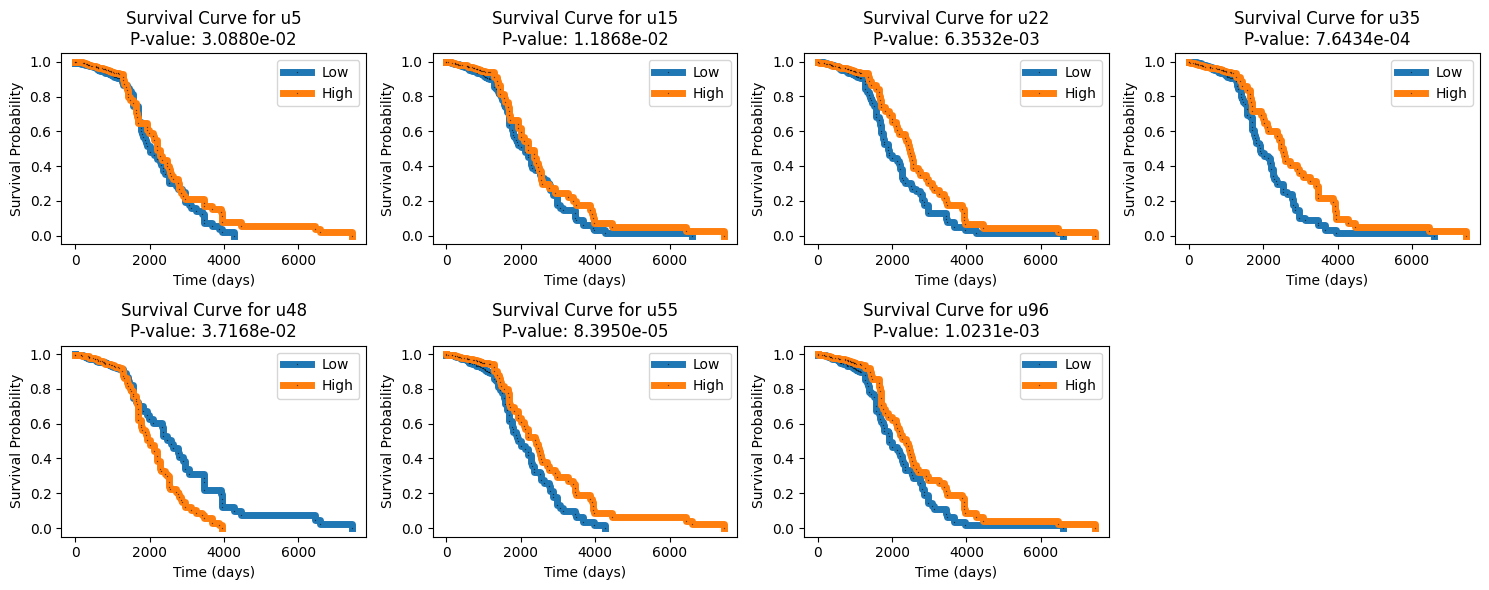

In [4]:
df_pmeta = pd.read_csv(wdir+'/unseen_analysis_patient/data/tcga_brca_clinical.csv.gz')


df_pmeta['time'] = df_pmeta['days_to_death'].fillna(df_pmeta['days_to_last_follow_up'])
df_pmeta['event'] = (df_pmeta['vital_status'] == 'Dead').astype(int)

# check for missing values
print(df_pmeta[['time', 'event']].isnull().sum())
median_time = df_pmeta['time'].median()
df_pmeta['time'].fillna(median_time, inplace=True)
df_pmeta = df_pmeta.set_index('Unnamed: 0')


from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt

selected_topics = []
def surv_plot(tag):
    df_latent = pd.DataFrame(new_adata.obsm[tag], index=new_adata.obs_names)
    df_latent = df_latent.loc[:, df_latent.median() != 0]

    df_latent.columns = ['u'+str(x)for x in df_latent.columns]
    
    selected_topics = ['u5', 'u15','u22','u35', 'u48','u55','u96']
    df_latent = df_latent.loc[:,selected_topics]
    
    df_latent = df_latent.loc[df_pmeta.index,:]
    df = pd.concat([df_pmeta[['time', 'event']], df_latent], axis=1)

    factors = df_latent.columns
    num_factors = len(factors)

    rows = 2
    cols = 4
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))  
    axes = axes.flatten()  
    kmf = KaplanMeierFitter()

    for idx, factor in enumerate(factors):
        median_value = df[factor].median()
        df['group'] = (df[factor] > median_value).astype(int)

        group_low = df[df['group'] == 0]
        group_high = df[df['group'] == 1]
        logrank_result = logrank_test(
            group_low['time'], group_high['time'], 
            event_observed_A=group_low['event'], 
            event_observed_B=group_high['event']
        )
        p_value = logrank_result.p_value

        if p_value > 0.05:
            continue
        selected_topics.append(factor)
        print(factor,p_value)
        
        for group, label in zip([0, 1], ['Low', 'High']):
            group_data = df[df['group'] == group]
            kmf.fit(group_data['time'], group_data['event'], label=label)
            kmf.plot_survival_function(ax=axes[idx],ci_show=False, linewidth=5,marker='+',markeredgecolor='black',markersize=0.2)

        axes[idx].set_title(f"Survival Curve for {factor}\nP-value: {p_value:.4e}")
        axes[idx].set_xlabel("Time (days)")
        axes[idx].set_ylabel("Survival Probability")
        axes[idx].legend()

    # remove empty plots
    for ax in axes[len(factors):]:
        ax.remove()

    plt.tight_layout()

surv_plot('picasa')

For the significant factors, check top genes according to model loadings.

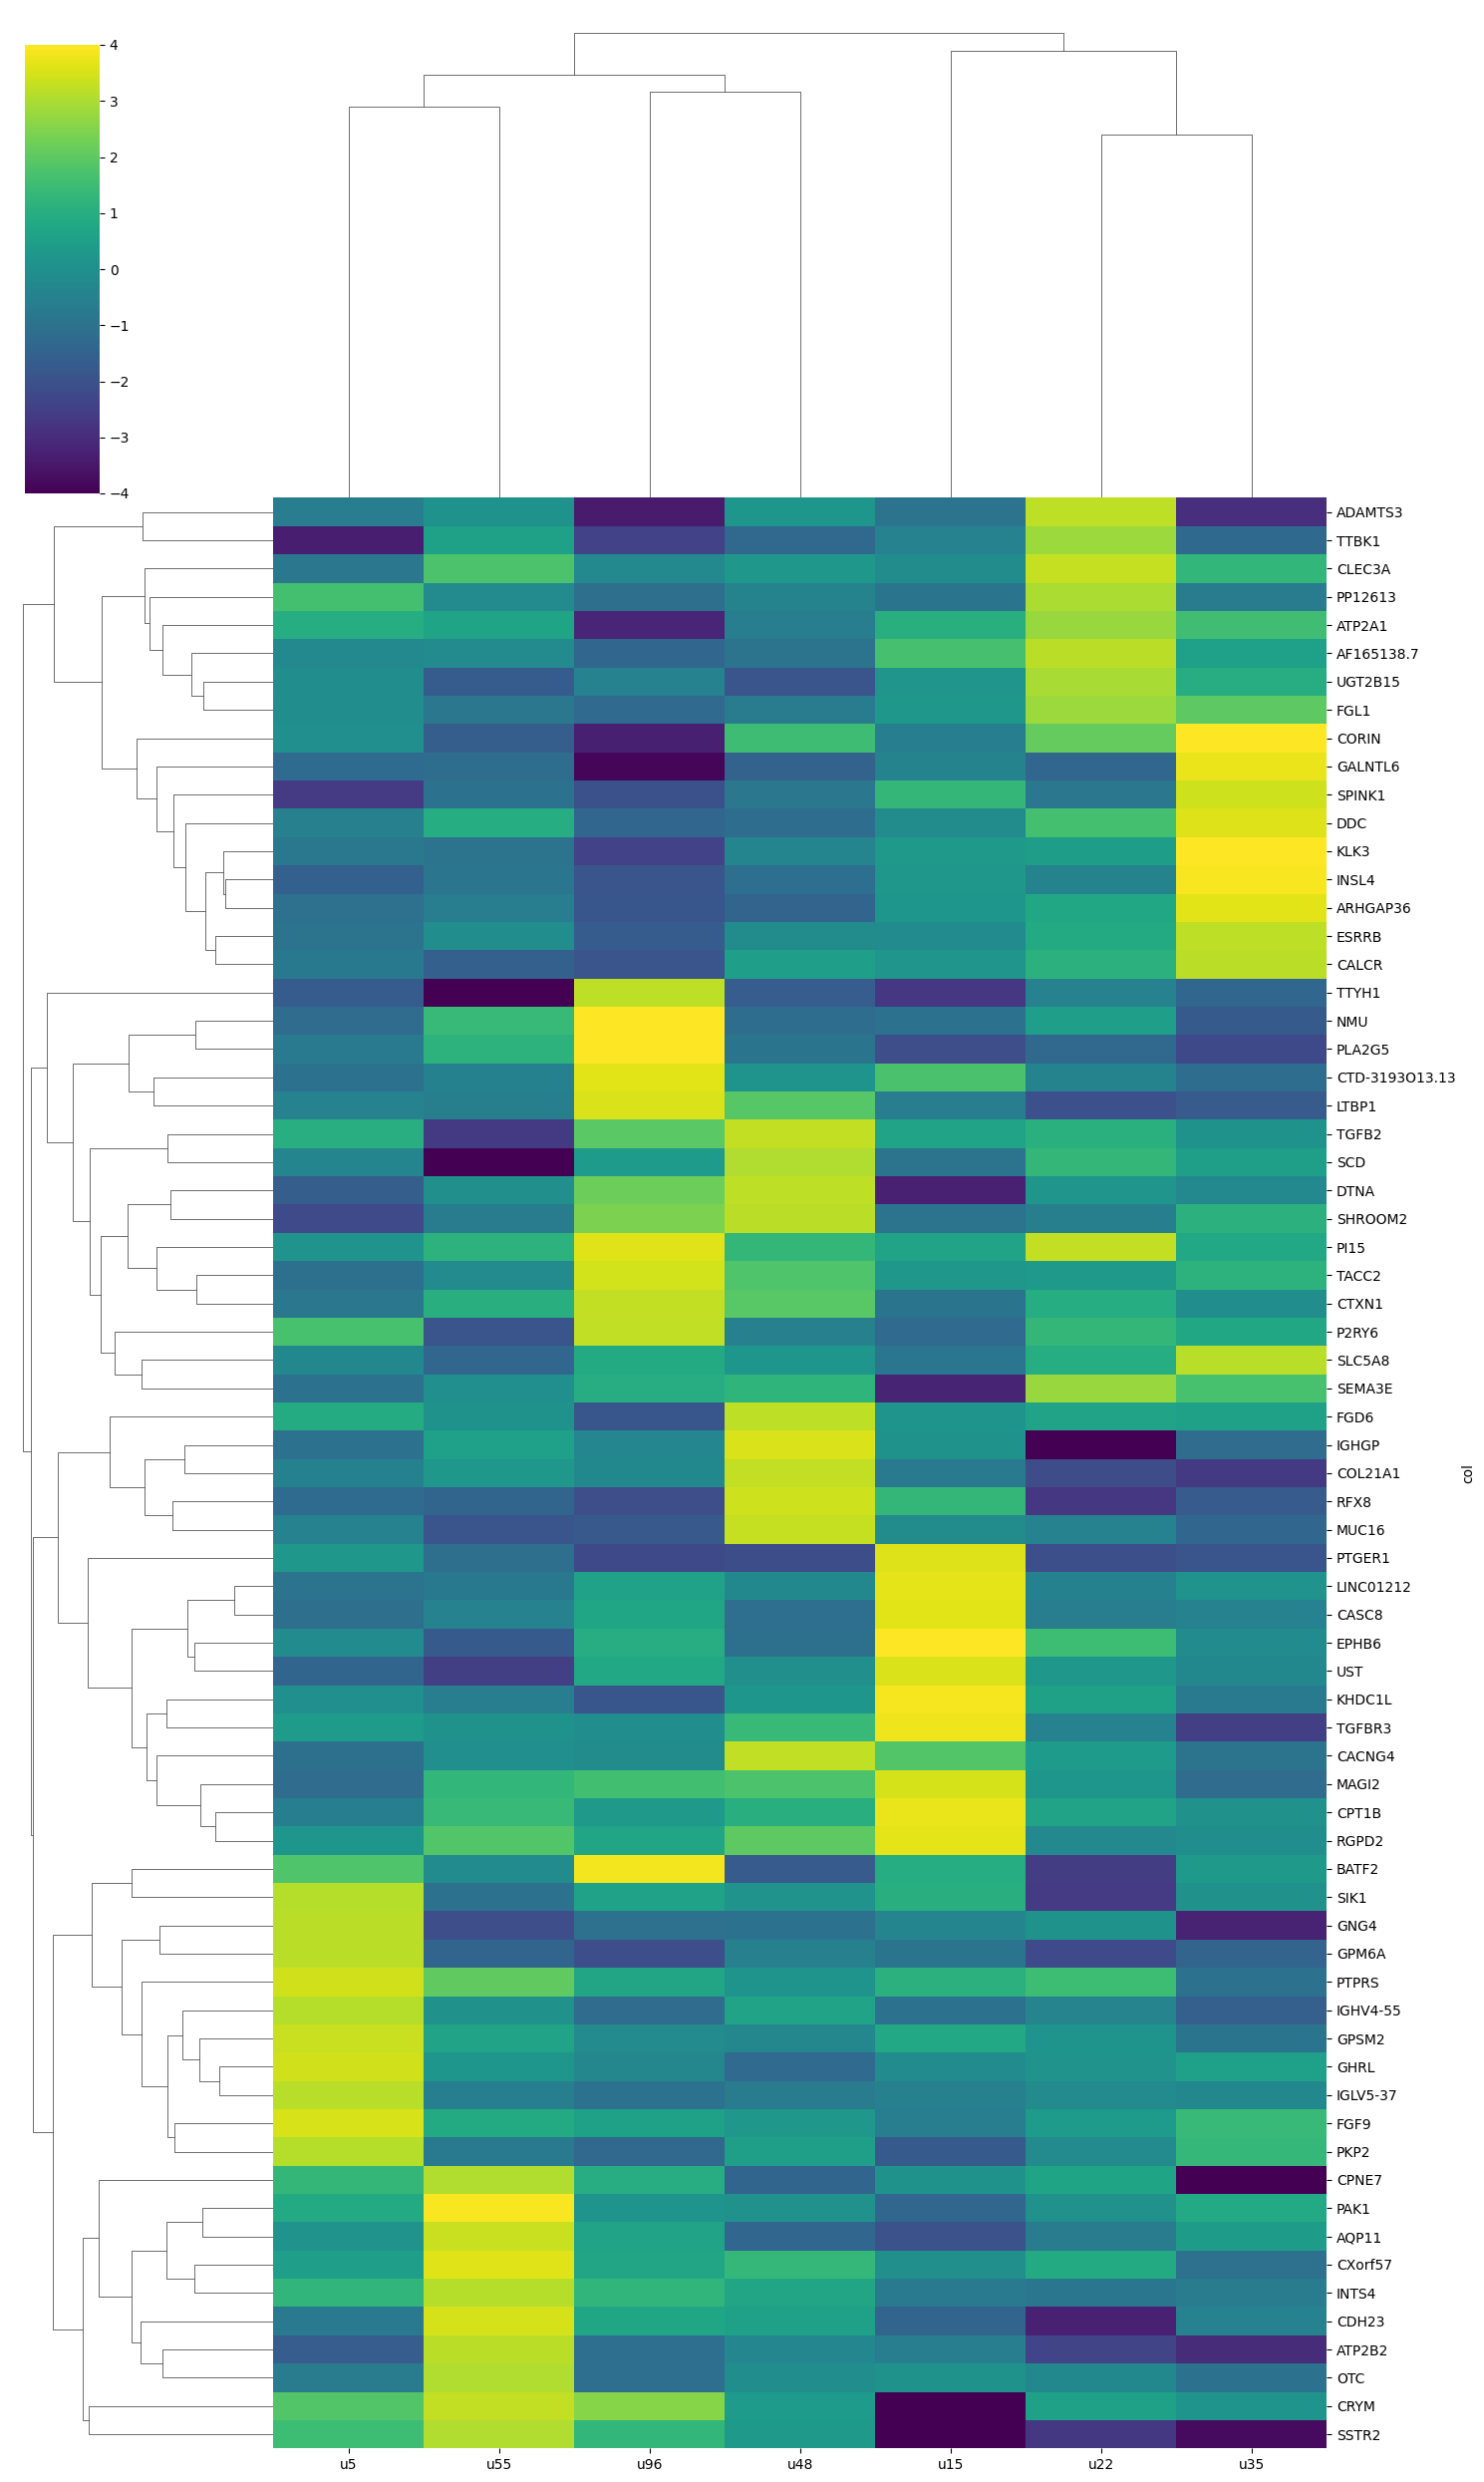

In [5]:


num_batches = len(picasa_adata.obs['batch'].unique())
input_dim = adata.shape[1]
nn_params = picasa_adata.uns['nn_params']
enc_layers = [128,25]
unique_latent_dim = nn_params['latent_dim']
common_latent_dim = nn_params['latent_dim']
dec_layers = [128,128]
nn_params['device'] = 'cpu'


picasa_unique_model = model.PICASAUniqueNet(input_dim,common_latent_dim,unique_latent_dim,enc_layers,dec_layers,num_batches).to(nn_params['device'])
picasa_unique_model.load_state_dict(torch.load(wdir+'/model_results/picasa_unique.model', weights_only=True, map_location=torch.device(nn_params['device'])))

picasa_unique_model.eval()


df_w = pd.DataFrame(picasa_unique_model.zinb_scale.weight.data.detach().cpu().numpy())

from scipy.stats import zscore

df_w = zscore(df_w, axis=0) 
df_w = df_w.T
df_w.columns = adata.var_names


####################################


def generate_gene_ranking(df,n_gene):

	gene_ranking = {}
	for x in df.index.values:
		h_gtab = df.T.loc[:,x].sort_values(ascending=False)[:n_gene].reset_index()
		h_gtab.columns = ['gene','val']
		h_genes = h_gtab['gene'].values
  
		gene_ranking[x] = h_genes

	return gene_ranking

def row_col_order(dfm):

	from scipy.cluster import hierarchy

	df = dfm.copy()
 
	Z = hierarchy.ward(df.to_numpy())
	ro = hierarchy.leaves_list(hierarchy.optimal_leaf_ordering(Z, df.to_numpy()))

	df['topic'] = df.index.values
	dfm = pd.melt(df,id_vars='topic')
	dfm.columns = ['row','col','values']
	M = dfm[['row', 'col', 'values']].copy()
	M['row'] = pd.Categorical(M['row'], categories=ro)
	M = M.pivot(index='row', columns='col', values='values').fillna(0)
	co = np.argsort(-M.values.max(axis=0))
	co = M.columns[co]
 
	return ro,co


####################################

selected_topics = ['u5', 'u15','u22','u35', 'u48','u55','u96']


df_w.reset_index(inplace=True)
df_w['index'] = ['u'+str(x) for x in df_w['index']]
df_w = df_w.loc[df_w['index'].isin(selected_topics)]
df_w.drop(columns={'index'},inplace=True)
df_w.reset_index(drop=True,inplace=True)

n_gene = 10
gene_ranking = generate_gene_ranking(df_w,n_gene)
all_genes = np.unique(np.concatenate([v for k,v in gene_ranking.items()]))
#####################################


## filter top genes and draw heatmap
df_w = df_w.loc[:,all_genes]
ro,co = row_col_order(df_w)
df_w = df_w.loc[ro,co]

df_w.index = np.array(selected_topics)[ro]
max_thresh = 4
df_w[df_w>max_thresh] = max_thresh
df_w[df_w<-max_thresh] = -max_thresh
sns.clustermap(df_w.T,
               yticklabels=df_w.columns,
               xticklabels=df_w.index,
               cmap='viridis',figsize=(15,25))

Similarly, for the significant factors, first rank all the genes according to model loadings and then run geneset enrichment analysis.

Running GSEA for KEGG_2021_Human


Running GSEA for MSigDB_Hallmark_2020
Running GSEA for Reactome_Pathways_2024


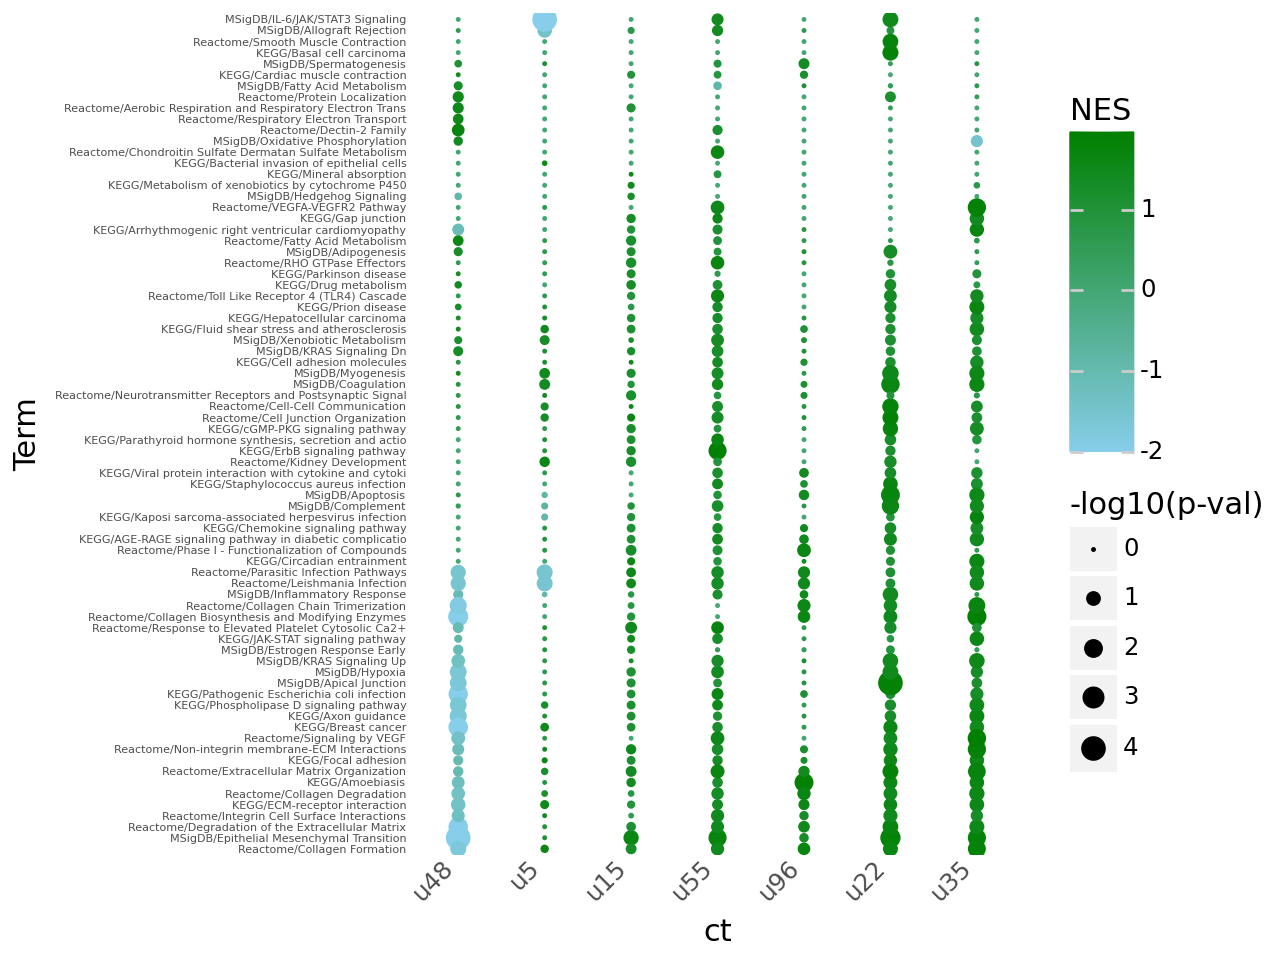

In [10]:

####################################

def generate_gene_ranking(df,n_gene):

	gene_ranking = {}
	for x in df.index.values:
		h_gtab = df.T.loc[:,x].sort_values(ascending=False)[:n_gene].reset_index()
		h_gtab.columns = ['gene','val']
		h_genes = h_gtab['gene'].values
  
		l_gtab = df.T.loc[:,x].sort_values(ascending=True)[:n_gene].reset_index()
		l_gtab.columns = ['gene','val']
		l_genes = l_gtab['gene'].values
		l_genes = l_genes[::-1]

		genes = np.concatenate([h_genes,l_genes])
  
		gene_ranking[x] = genes

	return gene_ranking


####################################

selected_topics = ['u5', 'u15','u22','u35', 'u48','u55','u96']

df_w.reset_index(inplace=True)
df_w['index'] = ['u'+str(x) for x in df_w['index']]
df_w = df_w.loc[df_w['index'].isin(selected_topics)]
df_w.set_index('index',inplace=True)


n_gene = 1000
gene_ranking = generate_gene_ranking(df_w,n_gene)

ranked_gene_list={}
for k,v in gene_ranking.items():
    df_c = df_w.loc[:,v]
    df_c = pd.DataFrame(df_c.loc[k].sort_values(ascending=False))
    df_c.reset_index(inplace=True)
    df_c.columns = ['Gene','Score']
    df_c['Score'] += np.linspace(1, 1.01 * df_c.shape[0], df_c.shape[0])
    ranked_gene_list[k] = df_c

import gseapy as gp
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
from plotnine import *
pd.set_option('future.no_silent_downcasting', True)


available_libraries = gp.get_library_name(organism="Human")

dbs = [
'KEGG_2021_Human',
'MSigDB_Hallmark_2020',
'Reactome_Pathways_2024'
]



unique_celltypes = list(ranked_gene_list.keys())

pval_col = 'FDR q-val' 
nes_col = 'NES'  
pval_col_log = '-log10(p-val)'
min_size, max_size = 10, 500  
top_n_pathways = 5

all_pathway_results = {}

df_main = pd.DataFrame()

for db in dbs:
	try:
		print(f"Running GSEA for {db}")
		gene_set_library = gp.get_library(name=db, organism="Human")

		all_pathways = []

		for factor in unique_celltypes:
			gsea_res = gp.prerank(
				rnk=ranked_gene_list[factor],
				gene_sets=gene_set_library,
				min_size=min_size,
				max_size=max_size,
				permutation_num=1000,
				outdir=None,
			)

			all_pathway_results[factor] = gsea_res.res2d

			top_paths = (
				gsea_res.res2d.sort_values(by=nes_col, ascending=False)
				.head(top_n_pathways)["Term"]
				.values
			)
			all_pathways.extend(top_paths)

		selected_pathways = np.unique(all_pathways)

		df_result = pd.DataFrame()

		for factor in unique_celltypes:
			df_gsea = all_pathway_results[factor].set_index("Term")

			df_gsea = df_gsea.reindex(selected_pathways)
			## 1 for pval	
			df_gsea[pval_col] = df_gsea[pval_col].fillna(1.0)
			## 0 for nes
			df_gsea[nes_col] = df_gsea[nes_col].fillna(0.0)  

			df_gsea["ct"] = factor
			df_result = pd.concat([df_result, df_gsea], axis=0)

		df_result[pval_col] = pd.to_numeric(df_result[pval_col], errors='coerce')
		df_result[nes_col] = pd.to_numeric(df_result[nes_col], errors='coerce')
		df_result[pval_col_log] = -np.log10(df_result[pval_col]+1e-8)
		df_result[pval_col_log] = df_result[pval_col_log].clip(lower=0, upper=4)
		df_result[nes_col] = df_result[nes_col].clip(lower=-2, upper=2)
  
		df_result['Term'] = [x.replace('Cells','') for x in df_result.index.values]
		df_result['Term'] = [x[:50] for x in df_result['Term']]
		df_result['Term'] = [db.split('_')[0]+'/'+x for x in df_result['Term']]

		df_main = pd.concat([df_main,df_result],axis=0)

	except Exception as e:  
		print(f"An unexpected error occurred: {e}")
		print(f'Failed.....{db}')


pivot_df = df_main.pivot(index="Term", columns="ct", values=nes_col)
def unique_max(row):
    max_value = row.max()
    return (row >= max_value).sum() == 1  

pivot_df = pivot_df[pivot_df.apply(unique_max, axis=1)]


row_linkage = linkage(pivot_df, method="ward")
col_linkage = linkage(pivot_df.T, method="ward")
row_order = leaves_list(row_linkage)
col_order = leaves_list(col_linkage)

df_main = df_main[df_main['Term'].isin(pivot_df.index.values)]

df_main["Term"] = pd.Categorical(df_main["Term"], categories=pivot_df.index[row_order], ordered=True)
df_main["ct"] = pd.Categorical(df_main["ct"], categories=pivot_df.columns[col_order], ordered=True)


p = (ggplot(df_main, aes(x='ct', y='Term', color='NES', size=pval_col_log)) 
		# + geom_point()
		+ geom_point(shape='o')
		+ scale_color_gradient(low="skyblue", high="green")				+ scale_size_continuous(range=(0, 4))
		+ theme(panel_grid=element_blank(),  
				panel_background=element_blank(),
				axis_line=element_blank(),  
				axis_ticks=element_blank(),  
				axis_text_x=element_text(rotation=45, hjust=1),
    			axis_text_y=element_text(size=4),
				plot_background=element_rect(fill='white', color='white',
				)  
				)  
)

p